# Setup

https://github.com/facebookresearch/faiss/wiki/Getting-started

**We assume row-major storage, ie. the j'th component of vector number i is stored in row i, column j of the matrix. Faiss uses only 32-bit floating point matrices.**

In [1]:
import numpy as np
import faiss

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Setup

In [3]:
xb = np.load('pred/feats_train.npy')
yb = np.load('pred/targs_train.npy')
xq = np.load('pred/feats_valid.npy')
yq = np.load('pred/targs_valid.npy')

In [4]:
xb.shape # nb-by-d

(57520, 512)

In [5]:
xq.shape # nq-by-d (query vectors)

(15476, 512)

In [6]:
yb.shape, yq.shape

((57520,), (15476,))

In [7]:
## setup
d = xb.shape[1] # 512
nlist = int(4*np.sqrt(xb.shape[0])) # https://github.com/facebookresearch/faiss/issues/112
d, nlist

(512, 959)

In [8]:
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

https://github.com/facebookresearch/faiss/wiki/FAQ#how-can-i-index-vectors-for-cosine-distance

In [9]:
xb.max()

30.879906

In [10]:
faiss.normalize_L2(xb)

In [11]:
xb.max()

0.24029064

In [12]:
index.train(xb)

In [13]:
index.add_with_ids(xb, yb)

In [14]:
print(index.is_trained)
print(index.ntotal)

True
57520


## Train dataset

In [15]:
## search
k = 5 # we want to see 5 nearest neighbors
D_train, I_train = index.search(xb, k) # sanity check
print(I_train[:5])
print(yb[:5].reshape((5,1)))
print(D_train[:5])

[[ 918  918  918  918  918]
 [ 868  868  868  868  868]
 [ 988  988  517  988  517]
 [1061 1061 1061 1061  594]
 [ 635  635  635  635  635]]
[[ 918]
 [ 868]
 [ 988]
 [1061]
 [ 635]]
[[0.99999994 0.8684271  0.8598705  0.842311   0.8089755 ]
 [0.99999994 0.9672351  0.96462953 0.96165943 0.9561436 ]
 [1.         0.962373   0.9623565  0.95946294 0.9566434 ]
 [1.0000002  0.8312677  0.7912695  0.78333855 0.73383045]
 [1.0000001  0.9142557  0.9122243  0.89097095 0.8823738 ]]


In [16]:
yb.max(), I_train.max()

(1107, 1107)

### Train accuracy

In [17]:
I_train[:,0].shape, yb.shape

((57520,), (57520,))

In [18]:
# Accuracy
np.equal(I_train[:,0], yb).sum()/len(yb)

1.0

In [19]:
I_train[:10,0], yb[:10]

(array([ 918,  868,  988, 1061,  635,  204,  868,  960,  428, 1107]),
 array([ 918,  868,  988, 1061,  635,  204,  868,  960,  428, 1107]))

In [20]:
I_train[-10:,0], yb[-10:]

(array([ 276,  428, 1029,   90,  406,  705, 1055,  984,  860,  997]),
 array([ 276,  428, 1029,   90,  406,  705, 1055,  984,  860,  997]))

### Train confusion matrix

In [21]:
cm = confusion_matrix(I_train[:,0], yb)

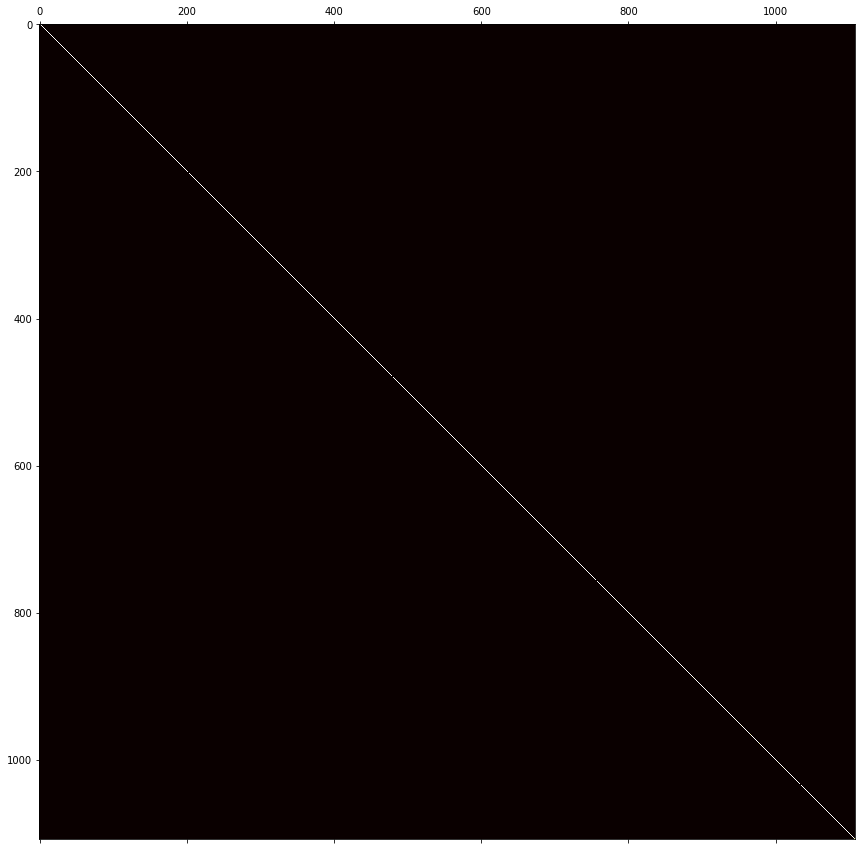

In [22]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

## Valid dataset

In [22]:
xq.max()

29.234863

In [23]:
faiss.normalize_L2(xq)

In [24]:
xq.max()

0.21924736

In [25]:
D_valid, I_valid = index.search(xq, k) # actual search

In [26]:
xq.shape, yq.shape

((15476, 512), (15476,))

In [27]:
I_valid.shape, D_valid.shape

((15476, 5), (15476, 5))

In [28]:
print(I_valid[:5]) # neighbors of the 5 first queries
print(yq[:5].reshape((5,1)))
print(D_valid[:5])

[[ 174  174  174  174  174]
 [ 932  932  932  932  932]
 [ 380  380  380  380  380]
 [ 949  927  927  927  949]
 [ 775  838 1056  155  775]]
[[352]
 [361]
 [503]
 [505]
 [ 70]]
[[0.5395553  0.49836904 0.47111267 0.46989477 0.46310252]
 [0.7265364  0.7227347  0.7013885  0.6993586  0.68853676]
 [0.7222799  0.720145   0.6968191  0.67827845 0.67674685]
 [0.55982816 0.546198   0.50476044 0.50245225 0.5017302 ]
 [0.59899503 0.5716789  0.566602   0.5627531  0.5624782 ]]


In [29]:
print(I_valid[-5:]) # neighbors of the 5 last queries
print(yq[-5:].reshape((5,1)))
print(D_valid[-5:])

[[ 109  990  556  109 1096]
 [   8   30   30   30   30]
 [ 948  948  948  948   -1]
 [ 795  795  795  795  795]
 [ 663  663  663  663  663]]
[[103]
 [202]
 [824]
 [328]
 [509]]
[[ 6.7047179e-01  5.9751916e-01  5.9399199e-01  5.9259176e-01
   5.7708895e-01]
 [ 6.0677111e-01  5.9973431e-01  5.7793880e-01  5.7017320e-01
   5.6702065e-01]
 [ 6.2501585e-01  6.1643839e-01  5.2918547e-01  4.8214650e-01
  -3.4028235e+38]
 [ 5.3512442e-01  5.0823891e-01  5.0040591e-01  4.7723663e-01
   4.6783781e-01]
 [ 6.8604159e-01  6.6128832e-01  6.6024435e-01  6.5947175e-01
   6.5240300e-01]]


In [30]:
np.save('pred/preds_valid.npy', I_valid)

### Valid accuracy

In [31]:
I_valid[:,0]

array([174, 932, 380, ..., 948, 795, 663])

In [32]:
yq

array([352, 361, 503, ..., 824, 328, 509])

In [33]:
# Correct elements
np.equal(I_valid[:,0], yq).sum()

5047

In [34]:
# Accuracy
np.equal(I_valid[:,0], yq).sum()/len(yq)

0.326117859912122

In [35]:
valid_correct = np.equal(I_valid[:,0], yq)

In [36]:
valid_correct

array([False, False, False, ..., False, False, False])

In [37]:
np.save('pred/preds_valid_correct.npy', valid_correct)

### Valid confusion matrix

In [38]:
cm = confusion_matrix(I_valid[:,0], yq)

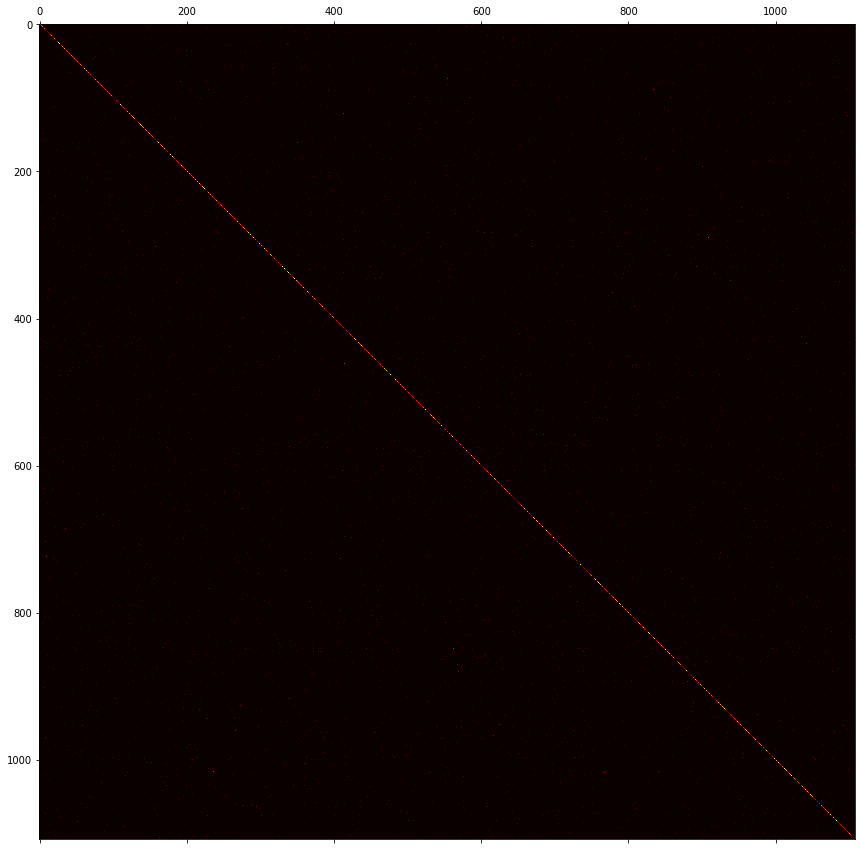

In [39]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

#### Work in progress

In [41]:
cm.shape

(1108, 1108)

In [42]:
np.eye(1108, dtype=bool)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [43]:
cm[np.eye(1108, dtype=bool)].sum()

1506

In [44]:
cm[~np.eye(1108, dtype=bool)].sum()

6232

In [45]:
cm[np.eye(1108, dtype=bool)].sum()/(cm[~np.eye(1108, dtype=bool)].sum() + cm[np.eye(1108, dtype=bool)].sum())

0.19462393383303178

In [46]:
~np.eye(1108, dtype=bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [47]:
cm[~np.eye(1108, dtype=bool)]

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
-(np.eye(1108)-1)

array([[-0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -0., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., -0.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -0.]])

In [49]:
cm * -(np.eye(1108)-1)

array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

In [50]:
cm_wodia = (cm * -(np.eye(1108)-1))

In [51]:
cm_wodia.shape

(1108, 1108)

In [52]:
cm_wodia.sum(axis=0)

array([3., 5., 4., ..., 7., 6., 5.])

In [53]:
cm_wodia.sum(axis=1)

array([ 9.,  6.,  1., ...,  3., 10.,  4.])

In [73]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, classes=np.unique(yq),
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, #classes=np.unique(yq), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Test dataset

In [40]:
xq_test = np.load('pred/feats_test.npy')

In [41]:
xq_test.max()

29.391468

In [42]:
faiss.normalize_L2(xq_test)

In [43]:
xq_test.max()

0.2273052

In [44]:
D_test, I_test = index.search(xq_test, k) # actual search

In [45]:
xq_test.shape, I_test.shape, D_test.shape

((39794, 512), (39794, 5), (39794, 5))

In [46]:
print(I_test[:5]) # neighbors of the 5 first queries
print(D_test[:5])

[[ 948  948  948  948   -1]
 [ 494  494  936  494  494]
 [  64   64   64   64   64]
 [1105 1105  165  165 1105]
 [ 445  445  445  445  445]]
[[ 5.4602003e-01  5.3721237e-01  5.2017272e-01  5.0978255e-01
  -3.4028235e+38]
 [ 6.2860984e-01  6.0528111e-01  6.0147381e-01  5.8074480e-01
   5.7118702e-01]
 [ 5.8274782e-01  5.0564408e-01  5.0279427e-01  4.7891623e-01
   4.4407487e-01]
 [ 7.2603232e-01  6.8692064e-01  6.7458308e-01  6.6187584e-01
   6.1034667e-01]
 [ 7.3439455e-01  7.0143068e-01  6.9593018e-01  6.4130020e-01
   6.3686371e-01]]


In [47]:
print(I_test[-5:]) # neighbors of the 5 last queries
print(D_test[-5:])

[[ 26  26  26  26  26]
 [316 316 316 316 316]
 [740 873 740 740 740]
 [524 524 524 524 524]
 [316 316 316 316 316]]
[[0.7659208  0.753866   0.7524275  0.75209856 0.7494996 ]
 [0.58071506 0.5725883  0.54206216 0.53761834 0.5343463 ]
 [0.4978966  0.4778502  0.46452308 0.46390095 0.4533691 ]
 [0.7242215  0.70987624 0.709792   0.70686543 0.69997853]
 [0.88884455 0.88847023 0.8860861  0.87347454 0.8702569 ]]


In [48]:
I_test[2]

array([64, 64, 64, 64, 64])

In [49]:
np.unique(I_test[2], return_counts=True)

(array([64]), array([5]))

In [50]:
preds_test = I_test[:,0]
dist_test = D_test[:,0]

In [51]:
np.save('pred/preds_test.npy', preds_test)
np.save('pred/dist_test.npy', dist_test)

#### Get mode or most similiar if mode is 1

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html#scipy.stats.mode

**This seems to not increase the accuracy !!!**

In [27]:
from scipy import stats

In [28]:
# get mode and mode count
I_test_mode = stats.mode(I_test, axis=1)

In [29]:
I_test.shape, I_test_mode[0].shape

((39794, 5), (39794, 1))

In [30]:
I_test[:5]

array([[ 591,  591,  587,  591,  855],
       [ 736,  770,  387,  728,  933],
       [ 179,  576,  191,  451, 1076],
       [ 908,  908,  609,  256,  892],
       [ 775,  445,  970,  387,  307]])

In [31]:
I_test_mode[0][:5]

array([[591],
       [387],
       [179],
       [908],
       [307]])

In [32]:
I_test_mode[1][:5]

array([[3],
       [1],
       [1],
       [2],
       [1]])

In [33]:
I_test_mode[1] == 1

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [34]:
mode_mask = (~(I_test_mode[1] == 1)).astype('float')
similar_mask = (I_test_mode[1] == 1).astype('float')

In [35]:
mode_mask[:5]

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [36]:
similar_mask[:5]

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [37]:
I_test[:,0]

array([ 591,  736,  179, ...,  108, 1074,  316])

In [38]:
similar_mask.shape

(39794, 1)

In [39]:
I_test[:,0].shape, similar_mask.shape

((39794,), (39794, 1))

In [40]:
I_test[:,0].reshape((-1,1)).shape

(39794, 1)

In [41]:
I_most_similar = np.multiply(I_test[:,0].reshape((-1,1)),similar_mask)

In [42]:
I_most_similar[:5]

array([[  0.],
       [736.],
       [179.],
       [  0.],
       [775.]])

In [43]:
I_higher_mode = np.multiply(I_test_mode[0],mode_mask)

In [44]:
I_higher_mode[:5]

array([[591.],
       [  0.],
       [  0.],
       [908.],
       [  0.]])

In [45]:
preds_similar_mode = I_most_similar + I_higher_mode

In [46]:
preds_similar_mode[:5]

array([[591.],
       [736.],
       [179.],
       [908.],
       [775.]])

In [51]:
np.save('pred/preds_test_similar_mask', similar_mask)
np.save('pred/preds_test_mode_mask', mode_mask)
np.save('pred/preds_test_similar_mode', preds_similar_mode)